# Data Lab 7
AR models

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
# Sep Nino 3.4
n34_Sep_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Sep/dods'
n34_Sep_ds = xr.open_dataset(n34_Sep_url)
n34_Sep = n34_Sep_ds.n34_Sep - n34_Sep_ds.n34_Sep.mean('T')
#n34_Sep.plot();

In [3]:
# 2-meter temperature
t2m_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_DJF/dods'
t2m_DJF_ds = xr.open_dataset(t2m_DJF_url)
t2m = t2m_DJF_ds.t2m_DJF
#t2m.mean('T').plot()

## Comments on homework 5

### 1. Weighted average
- Cosine weighting needs to be normalized
- "weighted" 
- mean('X').mean('Y') does not give you what you want which is mean(('X','Y')) when the domain is not a rectangle.

/opt/conda/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


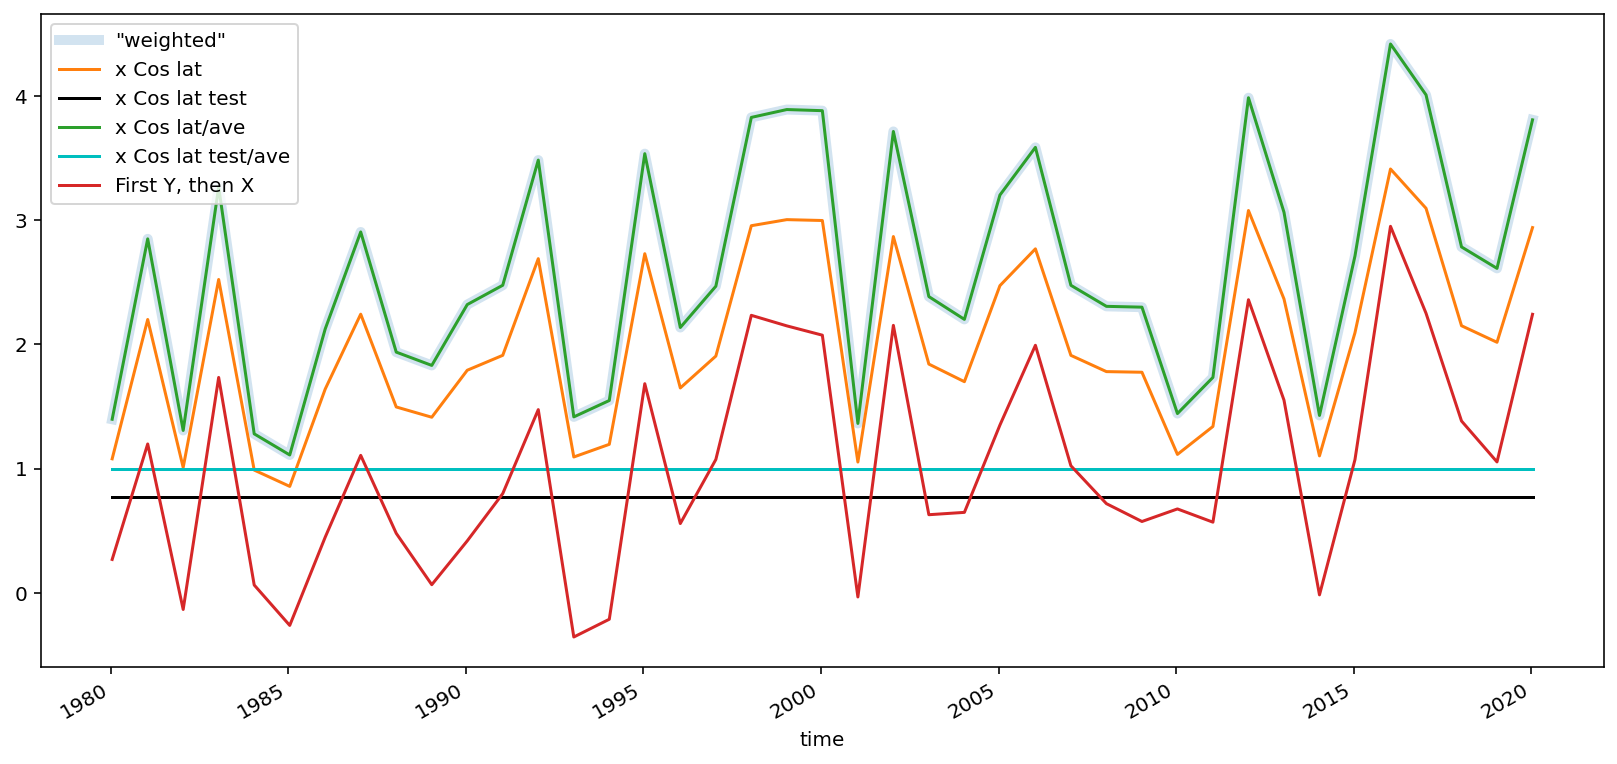

In [4]:
w = np.cos(np.deg2rad(t2m.Y))
w_normalized = w/(w * (t2m*0.0 + 1)).mean(('X', 'Y'))

fig, ax = plt.subplots(figsize = (14,6))
t2m.weighted(w).mean(('X', 'Y')).plot(ax = ax, linewidth = 5, alpha = 0.2, label = '"weighted"')

(t2m * w).mean(('X', 'Y')).plot(ax = ax, label = 'x Cos lat')
((t2m*0 + 1) * w).mean(('X', 'Y')).plot(ax = ax, color = 'k', label = 'x Cos lat test')

(t2m * w_normalized).mean(('X', 'Y')).plot(ax = ax, label = 'x Cos lat/ave')
((t2m*0 + 1) * w_normalized).mean(('X', 'Y')).plot(ax = ax, color = 'c', label = 'x Cos lat test/ave')

(t2m * w_normalized).mean('Y').mean('X').plot(ax = ax, label = 'First Y, then X')

ax.legend();

### 2. Linear regression on a map. 

Matrix-matrix multiplication = first matrix times the columns of the second matrix

If you want to multiply a matrix times a lot of (column) vectors, put the vectors in a matrix (columns).

In [5]:
ncol = 8
A = np.random.randint(-9, high=9, size = (3,3))
print(A)
print('---')

v = np.random.randint(-9, high=9, size = (3,ncol))
print(A @ v)
print('---')

for ii in range(0, ncol):
    print(A @ v[:,ii].reshape(-1,1), end='\n\n')
print('---')

v3d = np.reshape(v, (3,2,4))
for ii in range(0, 2):
    for jj in range(0, 4):
        print(A @ v3d[:,ii,jj].reshape(-1,1), end='\n\n')

[[ 5 -6 -9]
 [-3 -8  0]
 [ 0  4 -4]]
---
[[ 65 -46  24 -73  75 -74  18 -56]
 [  5  88  73   6  23 -80  10  60]
 [ 20 -56 -36 -28   0  -4  28 -56]]
---
[[65]
 [ 5]
 [20]]

[[-46]
 [ 88]
 [-56]]

[[ 24]
 [ 73]
 [-36]]

[[-73]
 [  6]
 [-28]]

[[75]
 [23]
 [ 0]]

[[-74]
 [-80]
 [ -4]]

[[18]
 [10]
 [28]]

[[-56]
 [ 60]
 [-56]]

---
[[65]
 [ 5]
 [20]]

[[-46]
 [ 88]
 [-56]]

[[ 24]
 [ 73]
 [-36]]

[[-73]
 [  6]
 [-28]]

[[75]
 [23]
 [ 0]]

[[-74]
 [-80]
 [ -4]]

[[18]
 [10]
 [28]]

[[-56]
 [ 60]
 [-56]]



In [6]:
# Linear regression at every gridpoint
from numpy.linalg import inv

N, nlat, nlon = t2m.shape
p = 2
XX = np.empty((N, p))
XX[:, 0] = 1
XX[:, 1] = n34_Sep[:-1]
y = t2m.values.reshape(N, nlat * nlon)

beta = inv(XX.T@XX)@XX.T@y
print(beta.shape)
yhat = XX@beta
R = y - yhat
sigma_hat = np.std(R, axis = 0)
print(sigma_hat.shape)

(2, 9424)
(9424,)


### 3. Tercile boundarys are also climatology (was not clear?). 

Also use all the data in the regression, not just climo period.

In [7]:
threshold_below = t2m.sel(T = slice('1980', '2010')).quantile([1./3., 2./3.], dim='T')

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


# "I come to bury AR, not to praise them"

Last time we fit an AR(1) model to Nino 3.4

$$ X_t = \phi X_{t-1} + W_t\,, $$

$$ E[X_t | x_0] = \phi^t x_0 $$

found that the residuals $X_t - \hat{X}_t = X_t - \hat{\phi} X_{t-1}$ were correlated in time, which led to an AR(2) model

$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + W_t\,, $$

whose residuals showed no evidence for autocorrelation.

Nonetheless, AR models are stationary. Their statistics are invariant to shifts in time.

In [8]:
# Read nino 3.4 and compute anomalies
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34/dods'
n34_ds = xr.open_dataset(n34_url)
n34 = n34_ds.n34
nmonths = len(n34)
n34a = n34.groupby('T.month') - n34.groupby('T.month').mean()

# Nino 3.4 is not stationary

## 1. Variance varies by month

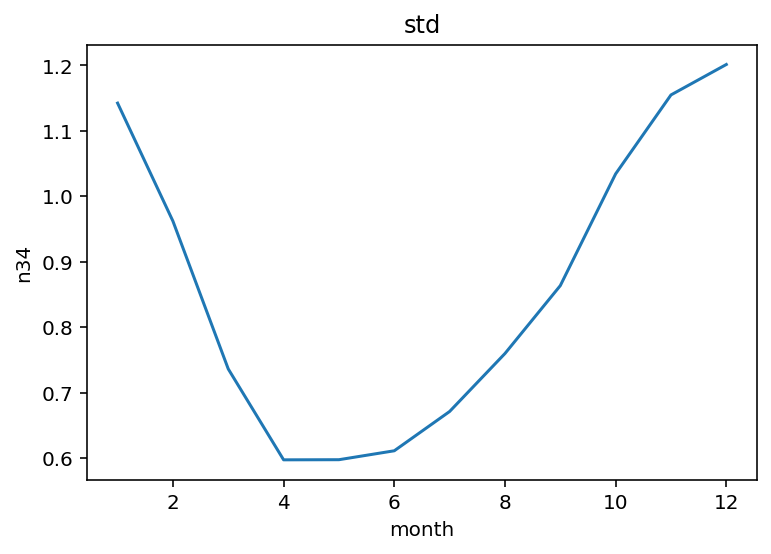

In [9]:
n34a.groupby('T.month').std(ddof = 1).plot()
plt.title('std');

The changes are larger than sampling variability

In [10]:
def std_by_month(x):
    nyears = np.floor_divide(len(x), 12)
    x2d = np.reshape(x[0:(nyears*12)], (nyears, 12))
    # bootstrap sampling to construct confidence intervals
    bootmax = 1000
    wrk = np.zeros((bootmax,12))
    for ii in range(0,bootmax):
        idx = np.random.choice(range(0,nyears),size=nyears)
        wrk[ii,:] = np.std(x2d[idx,:], ddof = 1, axis = 0)
    ci = np.percentile(wrk, np.array([5, 50, 95]), axis=0);
    return ci

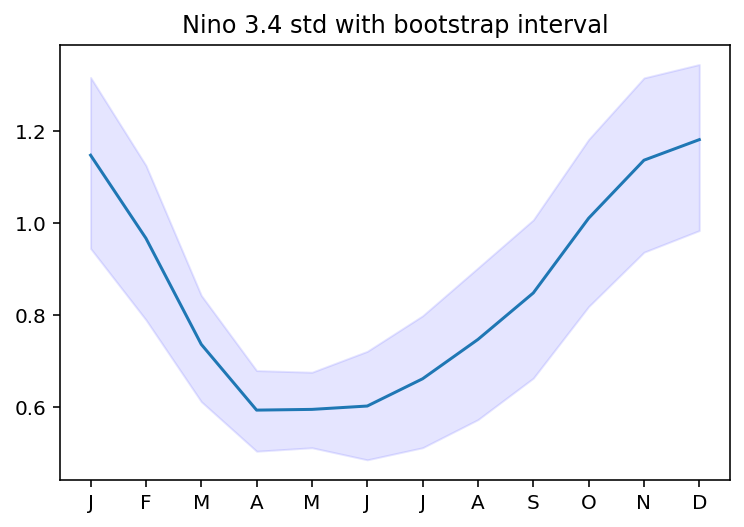

In [11]:
ci = std_by_month(n34a.values)
ci_obs = ci

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Nino 3.4 std with bootstrap interval');

### 1.1 Fit AR(1) 
To demonstrate that AR(1) does not get this variability

In [12]:
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)
X = np.empty((N,2)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 2)
phi1 = beta[1]

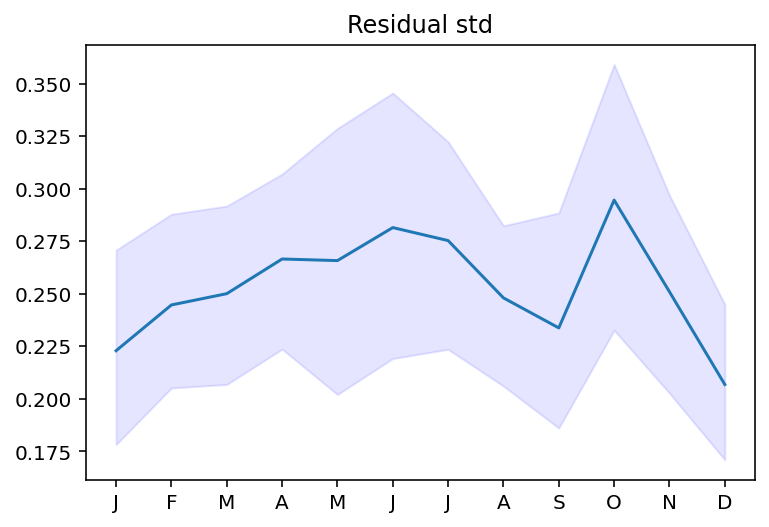

In [13]:
ci = std_by_month(np.roll(R,1))

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Residual std');

No overwhelming evidence for residuals that vary by month

### 1.2 Simulate the AR(1)

In [14]:
x = np.empty(N) + np.nan
sigma_X = np.sqrt(sigma_R**2/(1 - phi1**2))
x[0] = np.random.normal(scale = sigma_X)
x[0] = n34a[0]
for ii in range(1, N):
    x[ii] = phi1 * x[ii - 1] + np.random.normal(scale = sigma_R)

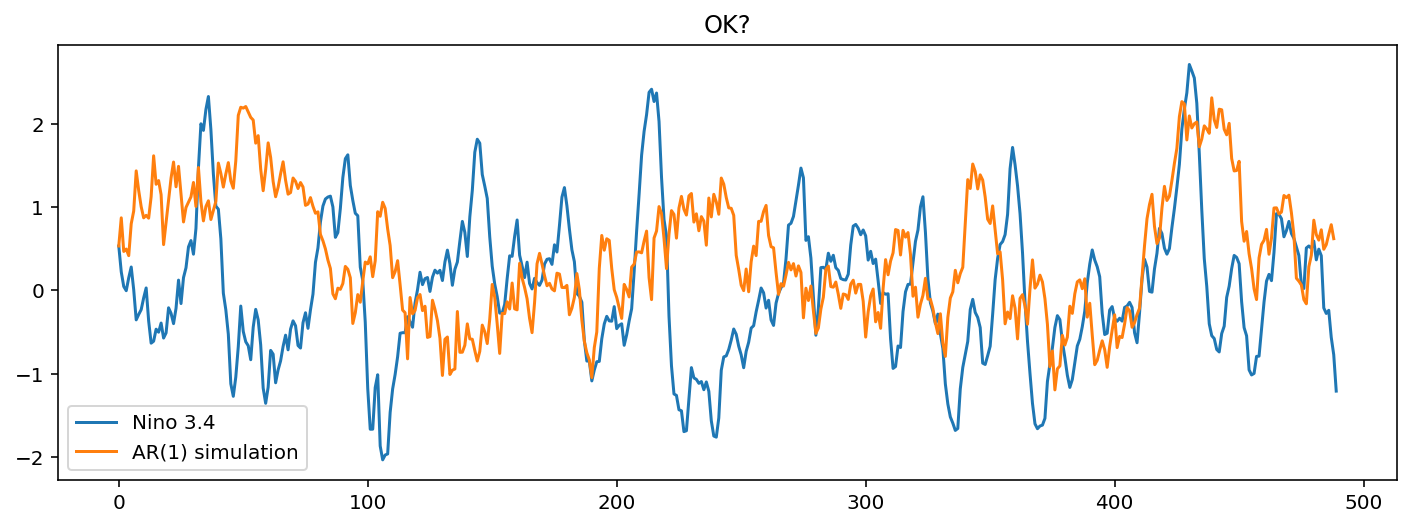

In [15]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(n34a.values, label = 'Nino 3.4')
ax.plot(x, label = 'AR(1) simulation');
ax.set_title('OK?');
ax.legend();

### 1.3 Check variance by month

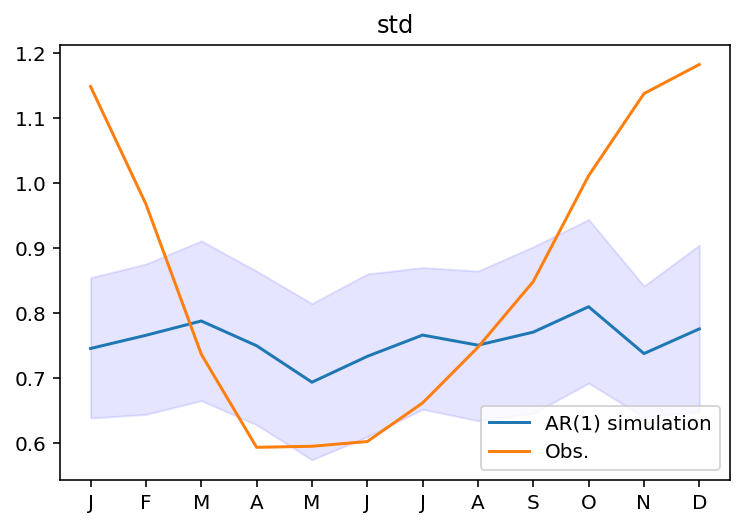

In [16]:
ci = std_by_month(np.roll(x,1))

fig, ax = plt.subplots()
#n34a.groupby('T.month').std(ddof = 1).plot(ax = ax)
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12),ci[1,:], label = 'AR(1) simulation')
ax.plot(np.arange(0,12),ci_obs[1,:], label = 'Obs.')
ax.legend()
ax.set_title('std');

### 1.4 Residuals are orthogonal to predictors ($X$)

Because regression is least-squares, and least-squares is projection.

![](images/ResidualsArePerp.pdf)

In [17]:
# And they are!
R.T @ X

array([ 8.10462808e-15, -1.76303416e-13])

Interpretation:

Residuals (errors) are uncorrelated with predictors. If errors were correlated with predictors, we could "fix" the errors by changing $\beta$.

(Picture above)

**But** residuals in some months do project onto predictors.

Recall the cosine of the angle $\theta$ between two vectors $a$ and $b$ (pretty much their correlation) is:
$$ \cos{\theta} = \frac{a^T b}{\|a\| \|b\|} $$

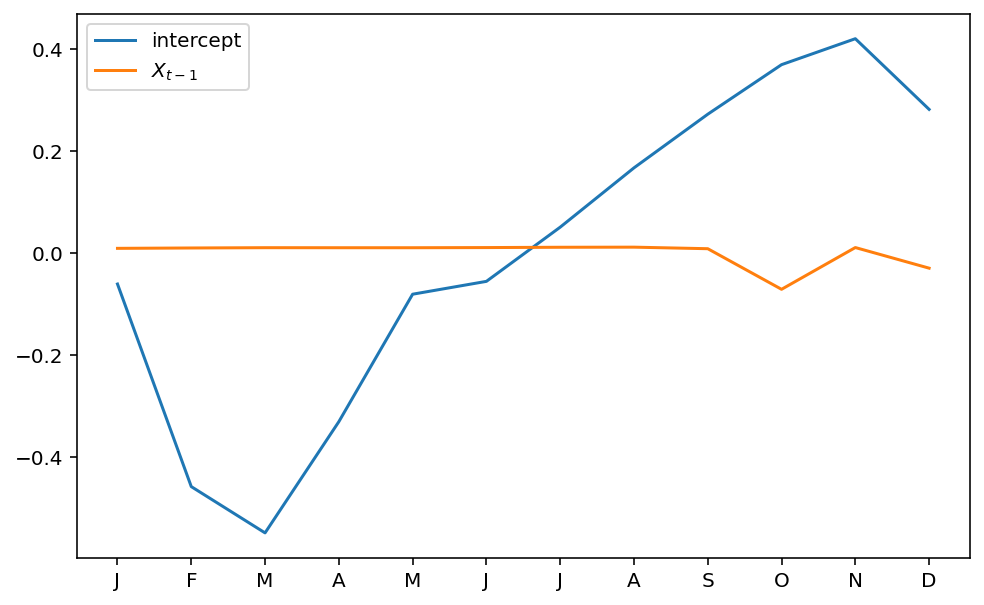

In [18]:
# compute correlation by month
dot = np.empty((12,2))
for imonth in range(0, 12):
    w1 = R[imonth::12]
    w2 = X[imonth::12, :]
    dot[imonth, :] = (w1.T @ w2)/np.sqrt(np.sum(w1**2)*np.sum(w2**2))

fig, ax = plt.subplots(figsize =(8, 5))    
ax.plot(np.roll(dot, 1))
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.legend(['intercept', '$X_{t-1}$']);

$R_t = X_t - \hat{X}_t = X_t - \phi X_{t-1}$ and $\phi \approx 0.95$ > 0.

So, the negative values in spring mean that $\hat{X}$ is too large in March, and the postive values mean that $\hat{X}$ is too small November.

The only way to fix this is to have a $\phi$ that varies by month.

Is there evidence that the autocorrelation is not just a function of the separation $\tau$?

In [19]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

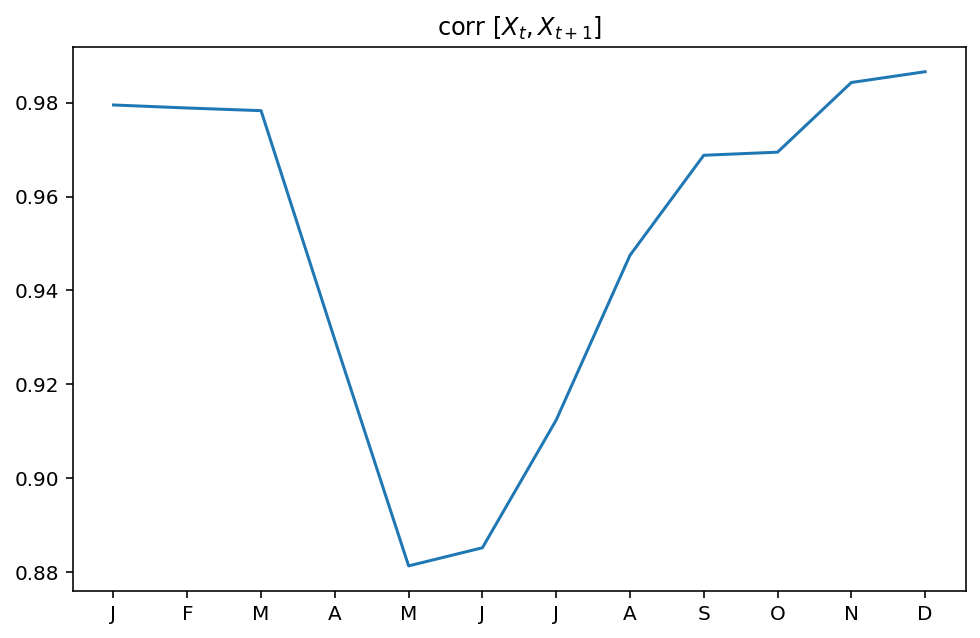

In [20]:
rho1 = np.empty(12) + np.nan
for imonth in range(0, 12):
    rho1[imonth] = cor(n34a[imonth::12], n34a.shift(T=1)[imonth::12])

fig, ax = plt.subplots(figsize =(8, 5))    
ax.plot(rho1)
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.set_title('corr [$X_t, X_{t+1}$]');

## 2. Periodic AR(1)

$$ X_{t} = \phi(t) X_{t-1} + W_t $$

where $\phi(t + 12) = \phi(t)$.

One approach: expand $\phi(t)$ in a Fourier series.

One harmonic $\phi(t) = a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) $

$$ X_{t} = \left( a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) \right) X_{t-1} + W_t $$

$$ X_{t} =  a_0 X_{t-1} + a_1 \sin (2\pi t/12) X_{t-1} + b_1 \cos (2\pi t/12) X_{t-1} + W_t $$



Two harmonics $\phi(t) = a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) + a_2 \sin (4\pi t/12) + b_2 \cos (4\pi t/12) $



In [21]:
# one harmonic in Fourier series
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)

mt = np.arange(0, N)/12.*2*np.pi

X = np.empty((N,4)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 4)
beta1 = beta
R1 = R

<ipython-input-21-49d751366045>:9: RuntimeWarning: invalid value encountered in add
  X = np.empty((N,4)) + np.nan


In [22]:
# two harmonics in Fourier series
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)

mt = np.arange(0, N)/12.*2*np.pi

X = np.empty((N,6)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)
X[:, 4] = n34a[0:-1] * np.sin(2*mt)
X[:, 5] = n34a[0:-1] * np.cos(2*mt)


beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 6)
beta2 = beta

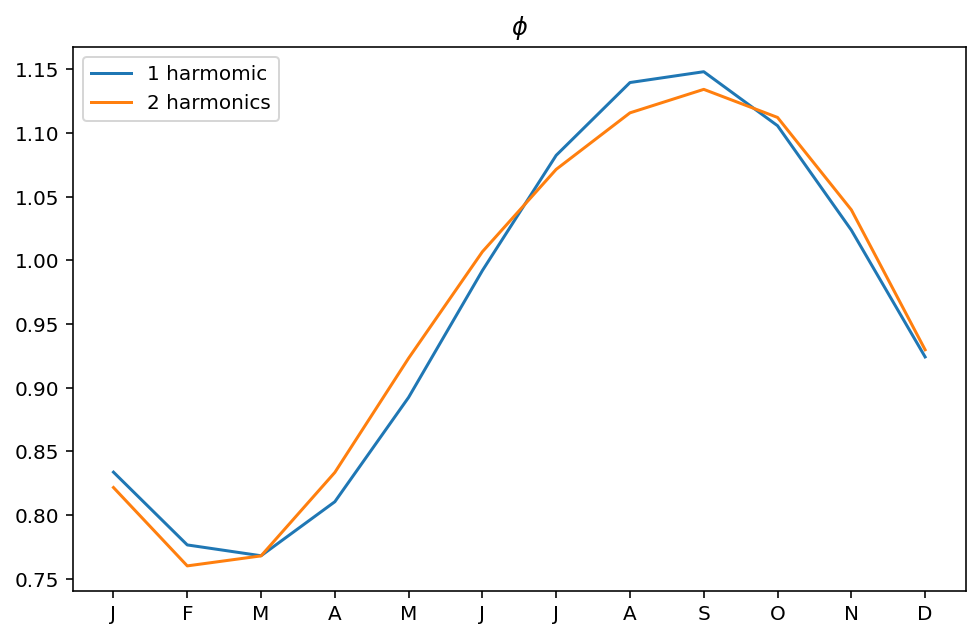

In [23]:
fig, ax = plt.subplots(figsize =(8, 5))    

ax.plot(beta1[1:] @ np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12])]),
        label = '1 harmomic')
ax.plot(beta2[1:] @ np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12]), np.sin(2*mt[:12]), np.cos(2*mt[:12])]),
        label = '2 harmonics')
ax.set_title('$\phi$')
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);

ax.legend();

Condition of $\phi$ for bounded solution?

$$ \prod_{i=1}^{12} \phi_i  < 1 $$

In [24]:
np.prod(beta1[1:] @ np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12])]))

0.5282051676306025

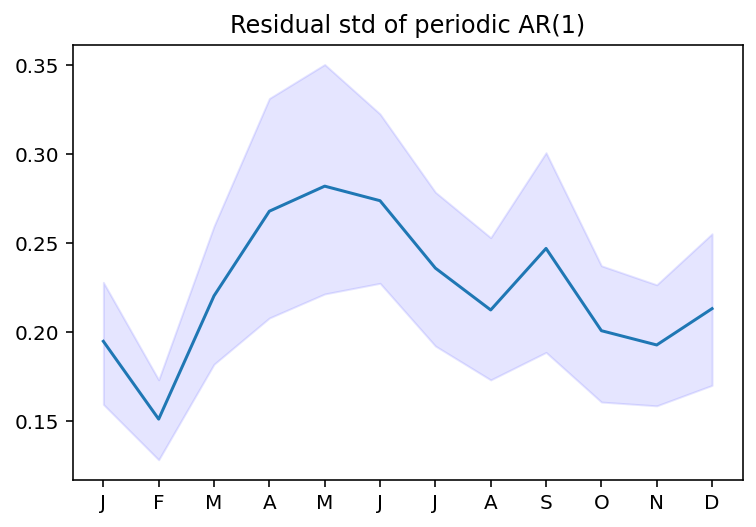

In [25]:
ci = std_by_month(R1)

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Residual std of periodic AR(1)');

In [26]:
A = np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12])]).T
r_std = ci[1,:]
alpha = inv(A.T @ A) @ (A.T @ r_std)
r_std_proj = A @ alpha

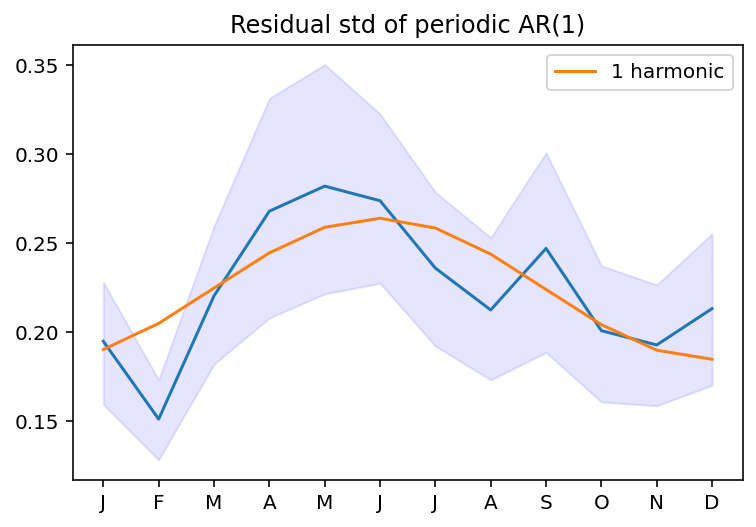

In [27]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
ax.plot(np.arange(0,12), r_std_proj, label = '1 harmonic')
ax.legend()
ax.set_title('Residual std of periodic AR(1)');

In [28]:
# Simulate periodic AR1
np.random.seed(2)

beta = beta1
x = np.empty(N) + np.nan
x[0] = n34a[0]
for ii in range(1, N):
    sigma_r = np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) @ alpha
    x[ii] = beta[0] + beta[1:] @ (np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) * x[ii - 1]) + np.random.normal(scale = sigma_r)

# rename for use later in homework
x_periodic_AR1 = x

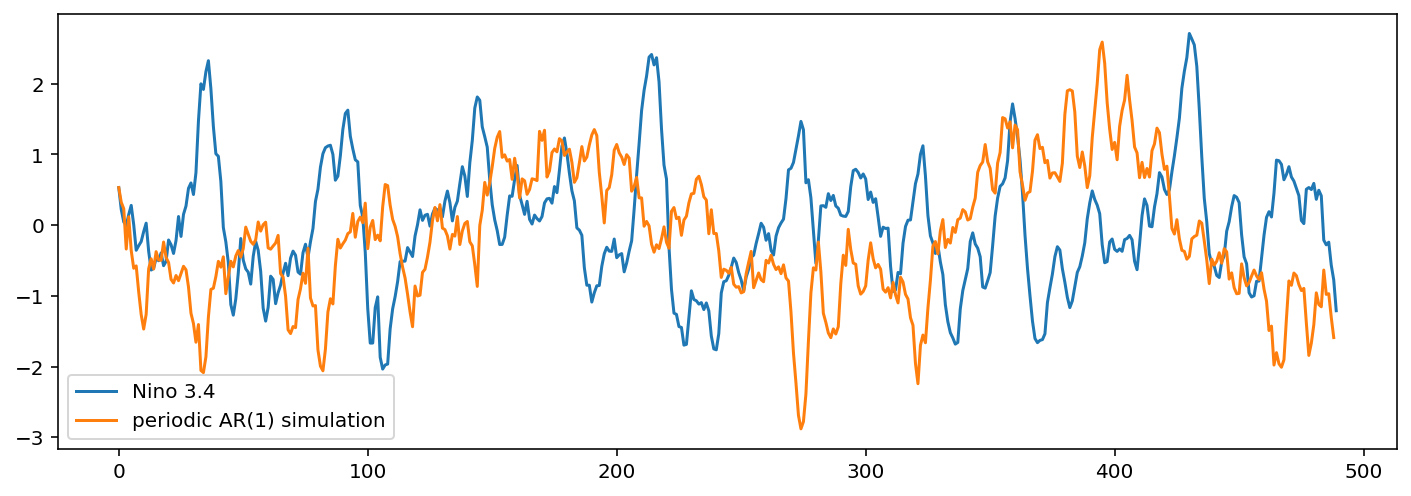

In [29]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(n34a.values, label = 'Nino 3.4')
ax.plot(x, label = 'periodic AR(1) simulation');

ax.legend();

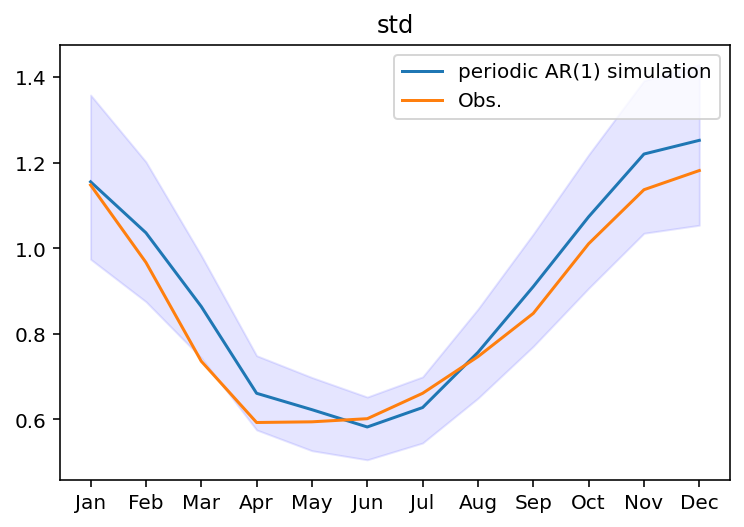

In [30]:
ci = std_by_month(np.roll(x,1))

fig, ax = plt.subplots()
#n34a.groupby('T.month').std(ddof = 1).plot(ax = ax)
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(month_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12),ci[1,:], label = 'periodic AR(1) simulation')
ax.plot(np.arange(0,12),ci_obs[1,:], label = 'Obs.')
ax.legend()
plt.title('std');

### 2.2 Residuals are still correlated

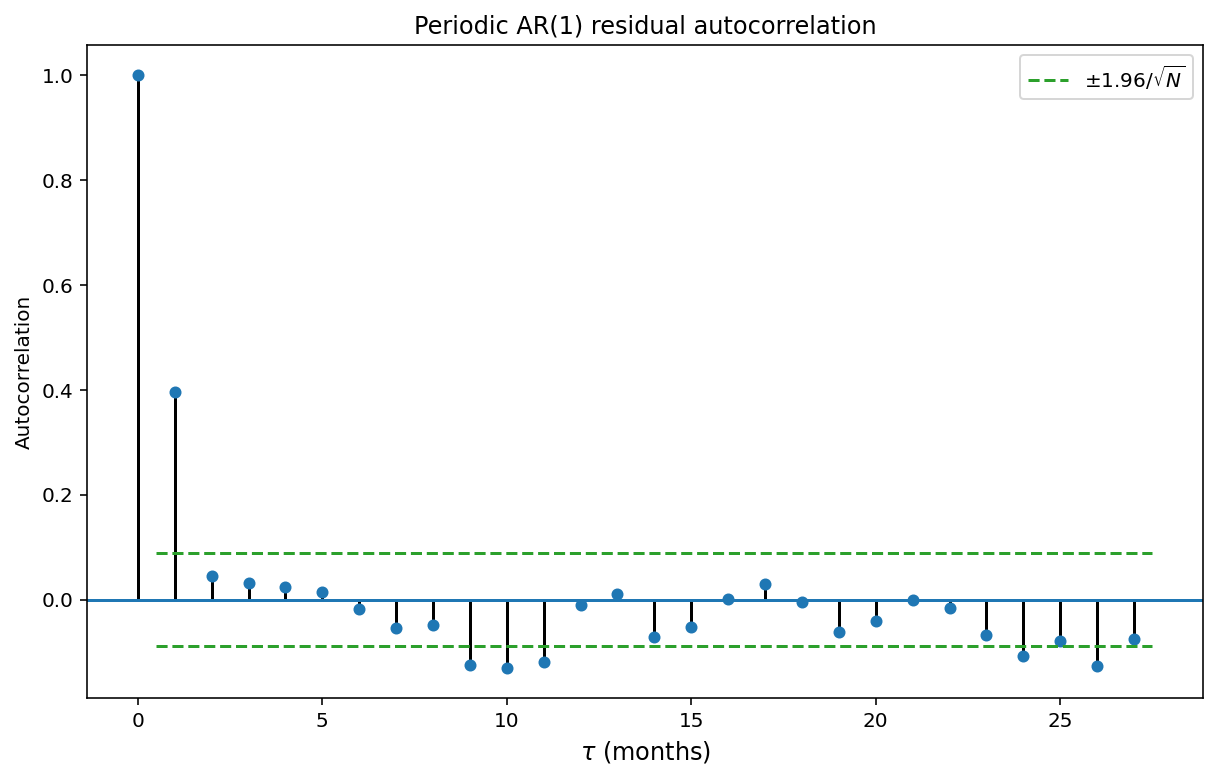

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 6))
#plot_acf(np.random.normal(size=nmonths), alpha = 0.05, ax = ax, title = 'Nino 3.4 autocorrelation');
plot_acf(R, alpha = None, ax = ax, title = 'Periodic AR(1) residual autocorrelation');

ax.set_xlabel(r'$\tau$ (months)', size = 12);
ax.set_ylabel('Autocorrelation')

c1 = np.ones(28)*1.96/np.sqrt(nmonths)
# interval for iid normal data
ax.plot(np.arange(0.5,28),  c1 , '--', color = colors[2], label = '$\pm 1.96/\sqrt{N}$')
ax.plot(np.arange(0.5,28), -c1 , '--', color = colors[2])
ax.legend();

## 3. Periodic AR2

$$ X_t = \phi_1(t) X_{t-1} + \phi_2(t) X_{t-2} + W_t $$

with 

$$\phi_1(t) = a_0 + a_1 \sin( 2 \pi t /12) + b_1 \cos( 2 \pi t/12) $$

$$\phi_2(t) = c_0 + d_1 \sin( 2 \pi t /12) + e_1 \cos( 2 \pi t/12) $$

### 3.1 Fit  

In [32]:
# one harmonic in Fourier series
from numpy.linalg import inv

y = n34a[2:].values
N = len(y)

mt = np.arange(0, N)/12.*2*np.pi

X = np.empty((N,7)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[1:-1]
X[:, 2] = n34a[1:-1] * np.sin(mt)
X[:, 3] = n34a[1:-1] * np.cos(mt)
X[:, 4] = n34a[0:-2]
X[:, 5] = n34a[0:-2] * np.sin(mt)
X[:, 6] = n34a[0:-2] * np.cos(mt)


beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 4)
beta1 = beta

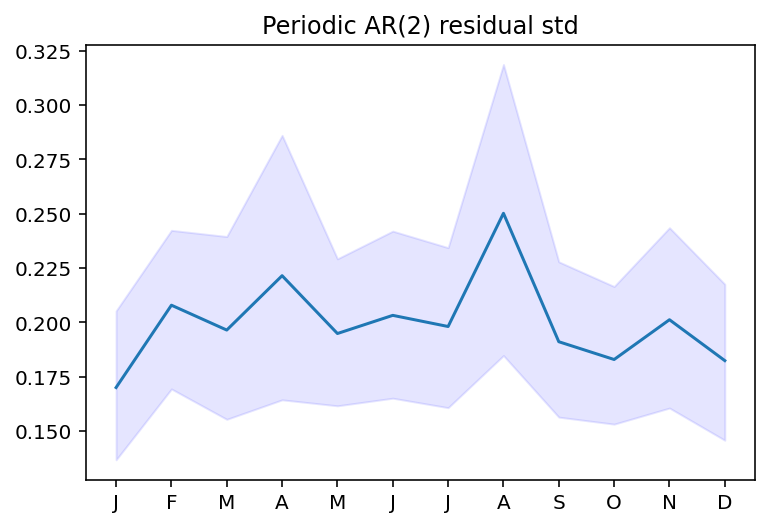

In [33]:
ci = std_by_month(R)

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Periodic AR(2) residual std');

Smaller. No strong evidence for monthly varying noise.

### 3.2 Simulate 

In [34]:
np.random.seed(3)

x = np.empty(N) + np.nan
x[0:2] = n34a[0:2]
for ii in range(2, N):
    x[ii] = beta[0] + beta[1:4] @ np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) * x[ii - 1] + beta[4:] @ np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) * x[ii - 2] + np.random.normal(scale = sigma_R)

# rename for use later in homework
x_periodic_AR2 = x

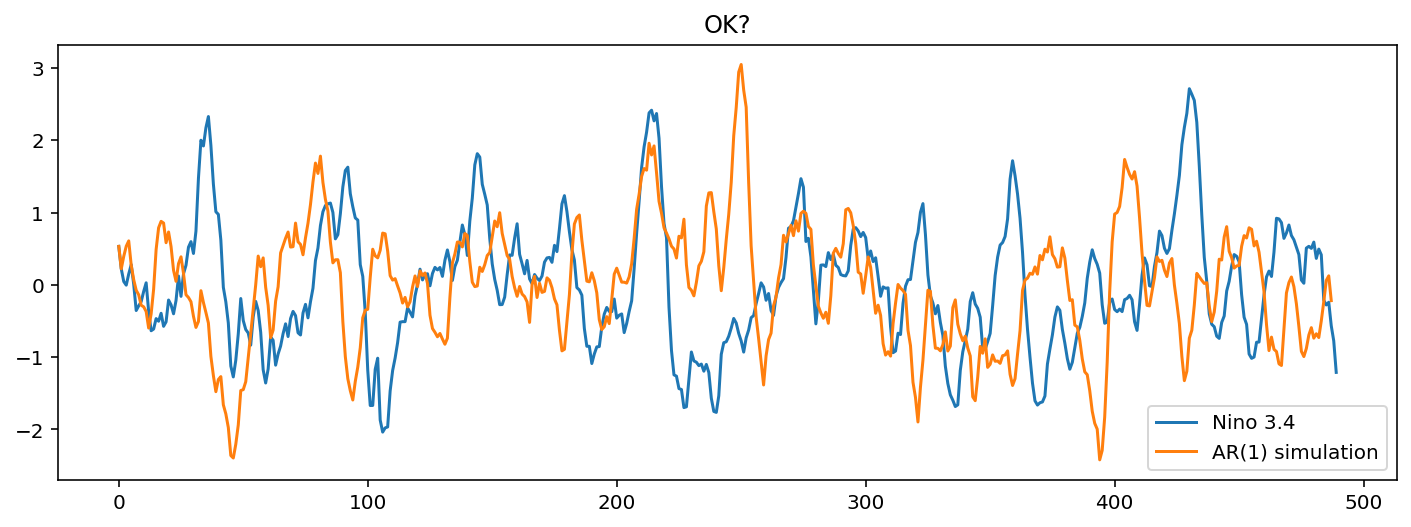

In [35]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(n34a.values, label = 'Nino 3.4')
ax.plot(x, label = 'AR(1) simulation');
ax.set_title('OK?');
ax.legend();

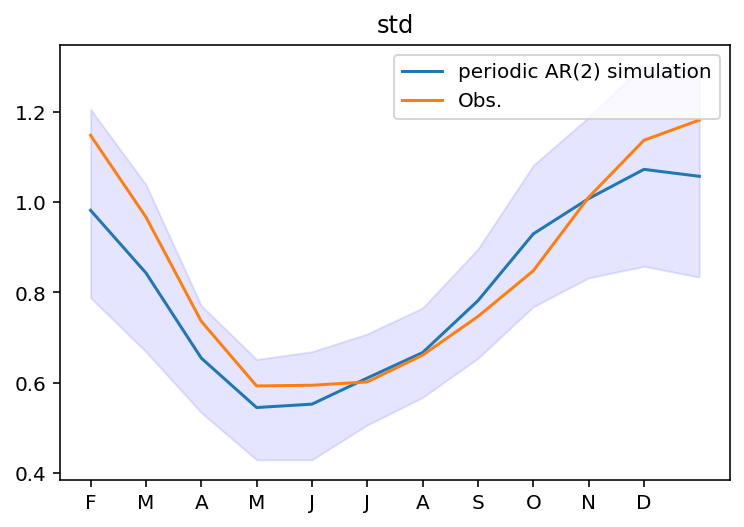

In [36]:
ci = std_by_month(np.roll(x,1))

fig, ax = plt.subplots()
#n34a.groupby('T.month').std(ddof = 1).plot(ax = ax)
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(1 + np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(1 + np.arange(0,12),ci[1,:], label = 'periodic AR(2) simulation')
ax.plot(1 + np.arange(0,12),ci_obs[1,:], label = 'Obs.')
ax.legend()
ax.set_title('std');

### 3.2 Residuals are uncorrelated

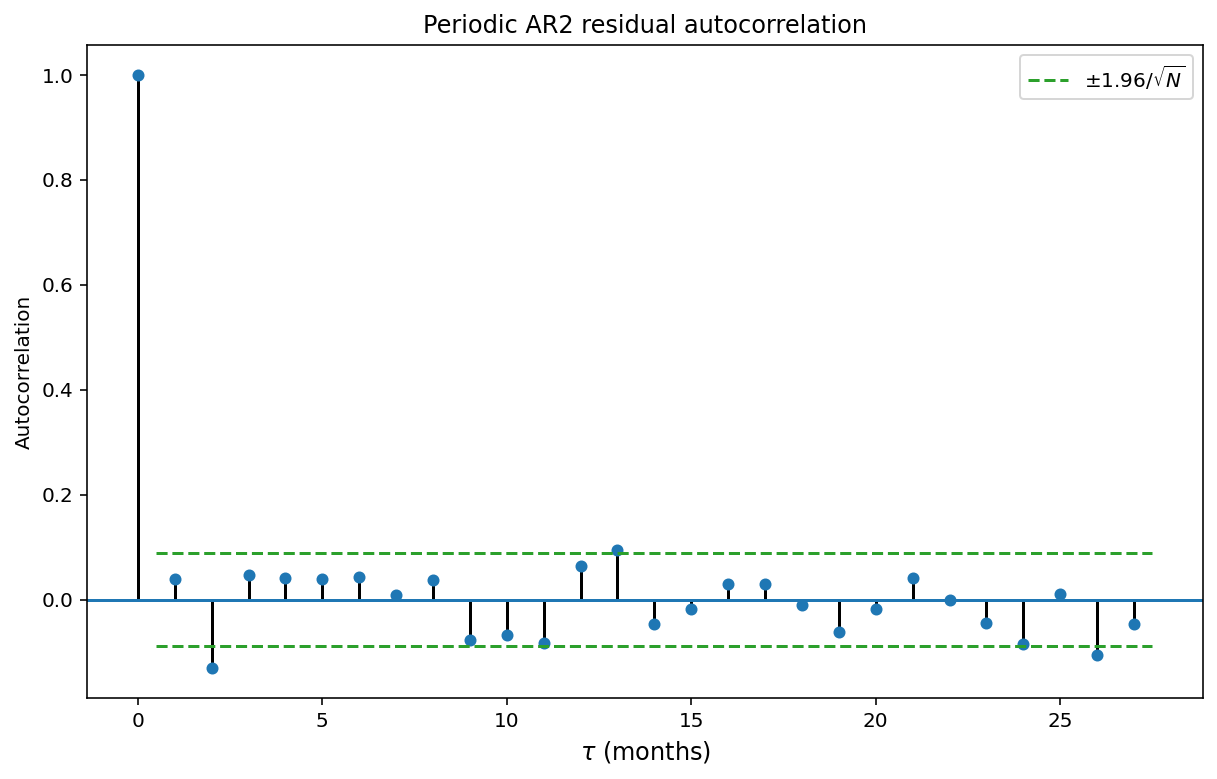

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 6))
#plot_acf(np.random.normal(size=nmonths), alpha = 0.05, ax = ax, title = 'Nino 3.4 autocorrelation');
plot_acf(R, alpha = None, ax = ax, title = 'Periodic AR2 residual autocorrelation');

ax.set_xlabel(r'$\tau$ (months)', size = 12);
ax.set_ylabel('Autocorrelation')

c1 = np.ones(28)*1.96/np.sqrt(nmonths)
# interval for iid normal data
ax.plot(np.arange(0.5,28),  c1 , '--', color = colors[2], label = '$\pm 1.96/\sqrt{N}$')
ax.plot(np.arange(0.5,28), -c1 , '--', color = colors[2])
ax.legend();

# Exercises

## 1. (20 points) 1. Project proposal (Turn in with homework)

Project ideas: 
1. ENSO blog index https://www.climate.gov/news-features/blogs/enso/index-page-enso-blog-posts
2. Possible formats/ideas
    - Reproduce/extend published work
    - Consider the role of ENSO on a topic that you have interest or experience
    - Ask me for an idea
    - Look at something from Michelle L'Heureux's talk
    - Look at SOI instead of Nino 3.4
    - Every lecture has gaps that could be filled and extended. For instance, what would the calculations of Walker look like using modern data?

Describe your project by answering the following questions.

1. What is the scientific question/hypothesis being addressed?

What is the seasonal influence of ENSO on the Eastern Pacific ITCZ? How do the El Nino indicies correlate to SST anamolies, sea surface levels, precipitation, and surface and upper PBL winds in the Eastern Tropical Pacific?  

2. What previous work has been done? (For instance, give a few references).

Reviews have been published on the correlation between El Nino/La Nina events and the SST and precipitation anomalies in the Eastern Pacific ITCZ [3]. In [2], linear regression analysis has been utilized to study the relationship between ENSO and ITCZ dynamics. Additionally, a similar study to basic correlations between the parameters listed above (SST anamolies, sea surface levels, precipitation, and surface and upper PBL winds) and ENSO index was performed for the Atlantic ITCZ [1], which gives me a good frame to work off of. 

[1] Münnich, Matthias, and J. Neelin. “Seasonal Influence of ENSO on the Atlantic ITCZ and Equatorial South America.” Geophysical Research Letters - GEOPHYS RES LETT 322 (November 16, 2005). https://doi.org/10.1029/2005GL023900. 

[2] Sulca, Juan, Ken Takahashi, Jhan-Carlo Espinoza, Mathias Vuille, and Waldo Lavado‐Casimiro. “Impacts of Different ENSO Flavors and Tropical Pacific Convection Variability (ITCZ, SPCZ) on Austral Summer Rainfall in South America, with a Focus on Peru.” International Journal of Climatology 38, no. 1 (2018): 420–35. https://doi.org/10.1002/joc.5185.

[3] Wang, Chunzai, and Paul C. Fiedler. “ENSO Variability and the Eastern Tropical Pacific: A Review.” Progress in Oceanography, A Review of Eastern Tropical Pacific Oceanography, 69, no. 2 (May 1, 2006): 239–66. https://doi.org/10.1016/j.pocean.2006.03.004.

3. What methods/approaches will be used?

I will perform a correlation analysis, similar to what we have doen in homeworks, between ENSO indices and the parameters listed above. Additionally, I will use linear regression to make a short term forecast within the given fields. 


4. What data will be used? Give as much detail as possible about the source, resolution (time and space), and format.

ENSO indicies:
 - Source: IRI LDEO (http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.nino/?Set-Language=en)
 - Resolution:
     - Temporal: Montly values, Nov 1981 - Sep 2020
 - Format: netCDF 
 
SST: 
 - Source: NOAA COBE SST (https://psl.noaa.gov/data/gridded/data.cobe.html
 - Resolution:
     - Temporal: Montly values, 01/1891 - Present
     - Spatial: 1 degree latitude X 1 degree longitude, from 89.5 N - 89.5 S and from 0.5 E to 359.5 E 
 - Format: netCDF 
 
Sea Surface Level Anomalies: 
 - Source: APDRC (http://apdrc.soest.hawaii.edu/datadoc/aviso_upd_msla_mon.php)
 - Resolution:
     - Temporal: Montly values, 06/1992 - 07/2013
     - Spatial: 1/3 degree latitude X 1/3 degree longitude
 - Format: OpeNDAP 

Precipitation: 
 - Source: NOAA CMAP (https://psl.noaa.gov/data/gridded/data.cmap.html) 
 - Resolution:
     - Temporal: Montly values, 01/1979 - 09/2020
     - Spatial: 2.5 degree latitude X 2.5 degree longitude, from 88.75 N - 88.75 S and from 1.25 E to 358.75 E 
 - Format: netCDF 
 
Winds: 
 - Source: ERA 5 Reanalysis (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) 
 - Resolution:
     - Temporal: Montly values, 1979 - Present
     - Spatial: 0.25 degree latitude X 0.25 degree longitude
 - Format: GRIB


## 2. (20 points) A mean-zero AR(3) model has the form

$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + W_t $$ 

where $W_t$ is Gaussian white noise with mean zero and variance $\sigma_W^2$. Suppose that process is stationary with variance $\sigma_X^2$.

A. Show that $E[X_t] = 0$. (Take expectation of both sides of the above equation and use stationarity).

$$
    E[X_t] = E[\phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + W_t] = \phi_{1}E[X_{t-1}] + \phi_{2}E[X_{t-2}] + \phi_{3} E[X_{t-3}] + E[W_{t}]
$$

$$
    \mu = \phi_{1} \mu + \phi_{2} \mu + \phi_{3} \mu + 0 \Longrightarrow \mu(1 - \phi_{1} - \phi_{2} - \phi_{3}) = 0 
$$

$$
    (1 - \phi_{1} - \phi_{2} - \phi_{3}) \neq 0 \Longrightarrow \boxed{\mu = E[X_{T}] = 0}
$$

B. Multiply both sides of the equation above by $X_{t - k}/\sigma_X^2$ for $k > 0$ and take the expectation. Express the result using the autocorrelation function $\rho(\tau) = \text{cor} [X_t, X_{t-\tau} ]$. 

First, I'll note that the autocorrelation function is related to the covariance of a process at different times by

$$
    \rho(\tau) = \text{cor}[X_{t}, X_{t + \tau}] = \frac{\text{cov}[X_{t}, X_{t+\tau}]}{\sqrt{\text{var}[X_{t}] \text{var}[X_{t + \tau}]}} \quad \quad \text{where} \ \ \rho(-\tau) = \rho(\tau) 
$$

Multiplying the AR(3) model by $X_{t - k}/\sigma_X^2$ for $k > 0$, we can then use the linearity of the expected value operator:  

$$
    \frac{1}{\sigma_{X}^{2}} E[X_{t} X_{t-k}] = \frac{\phi_{1}}{\sigma_{X}^{2}} E[X_{t-1} X_{t-k}] + \frac{\phi_{2}}{\sigma_{X}^{2}} E[X_{t-2} X_{t-k}] + \frac{\phi_{3}}{\sigma_{X}^{2}} E[X_{t-3} X_{t-k}] + \frac{1}{\sigma_{X}^{2}} E[W_{t} X_{t - k}]
$$

Looking at the first term, let's recall that the mean of the stationary system is $0$. In that case, the expected value of the product of two varaibles at different timesteps can be reduced to the covariance: 

$$
    \frac{1}{\sigma_{X}^{2}} E[X_{t} X_{t-k}] = \frac{\text{cov}[X_{t}, X_{t-k}]}{\sigma_{X}^{2}} = \rho(k)
$$


Similarly, for the other terms on the right hand side: 

$$
\frac{\phi_{1}}{\sigma_{X}^{2}} E[X_{t-1}X_{t-k}] = \phi_{1} \rho(k-1) 
$$

$$
\frac{\phi_{2}}{\sigma_{X}^{2}} E[X_{t-2}X_{t-k}] = \phi_{2} \rho(k-2)
$$

$$
\frac{\phi_{3}}{\sigma_{X}^{2}} E[X_{t-3}X_{t-k}] = \phi_{3} \rho(k-3) 
$$

The last term on the RHS has the expectation of the product of the process and the white noise. The product and the white noise are not independent (as described by the AR(3) model). We can then say

$$
\frac{1}{\sigma_{X}^{2}}E[W_{t}X_{t-k}] = \frac{1}{\sigma_{X}^{2}}E[(W_{t}-0)((X_{t-k}-0)] = \frac{\text{cov}[W_{t}, X_{t-k}]}{\sigma^{2}_{X}} = \frac{\sigma_{W}}{\sigma_{X}}\rho(k)
$$

Taking the expectation of the full product formula is then

$$
    \rho(k) = \phi_{1} \rho(k-1) + \phi_{2} \rho(k-2) + \phi_{3} \rho(k-3) + \frac{\sigma_{W}}{\sigma_{X}}\rho(k)
$$

C. Use the result from B and set $k = 1, 2, 3$ to obtain 3 equations involving the $\phi$'s and $\rho(1)$, $\rho(2)$, and $\rho(3)$. Use the fact that $\rho(\tau)$ is an even function of $\tau$.

Recall that $\rho(0) = \frac{c(0)}{c(0)} = 1$. When $k = 1$: 


$$
    \rho(1) = \phi_{1} + \phi_{2} \rho(1) + \phi_{3} \rho(2) + \frac{\sigma_{W}}{\sigma_{X}}\rho(1) \quad \quad \text{Eq (1)}
$$

When $k=2$: 

$$
    \rho(2) = \phi_{1} \rho(1) + \phi_{2} + \phi_{3} \rho(1) + \frac{\sigma_{W}}{\sigma_{X}}\rho(2) \quad \quad \text{Eq (2)}
$$

When $k = 3$: 

$$
    \rho(3) = \phi_{1} \rho(2) + \phi_{2} \rho(1) + \phi_{3} + \frac{\sigma_{W}}{\sigma_{X}}\rho(3) \quad \quad \text{Eq (3)}
$$


D. Use the values of $\rho(1)$, $\rho(2)$, and $\rho(3)$ and solve for $\phi_1$, $\phi_2$, $\phi_3$.

First, let's use Eq (1) and Eq (3) to eliminate $\phi_{2}$: 

$$
    \rho(1) - \rho(3) = \phi_{1}(1 - \rho(2)) + \phi_{3}(\rho(2) - 1) + \frac{\sigma_{W}}{\sigma_{X}}(\rho(1) - \rho(3)) \quad \quad \text{Eq (4)}
$$

Next, we can use Eq (1) $ - \rho(1) \times$Eq(2) to eliminate $\phi_{2}$: 

$$
    \rho(1)(1 - \rho(2)) = \phi_{1}(1 - \rho(1)^{2}) + \phi_{3} (\rho(2) - \rho(1)^{2}) + \frac{\sigma_{W}}{\sigma_{X}} (\rho(1)(1 - \rho(2)) \quad \quad \text{Eq (5)}
$$

Use Eq (4) to solve for $\phi(1)$ in terms of $\phi(3)$: 

$$
    \phi_{1} = (1 - \rho(2))^{-1} \bigg(\rho(1) - \rho(3) - \phi_{3}(\rho(2) - 1) - \frac{\sigma_{W}}{\sigma_{X}}(\rho(1) - \rho(3))\bigg)
$$

Plug this into Eq (5) and solve for $\phi(3)$: 

$$
      \rho(1)(1 - \rho(2)) = (1 - \rho(2))^{-1} \bigg(\rho(1) - \rho(3) - \phi_{3}(\rho(2) - 1) - \frac{\sigma_{W}}{\sigma_{X}}(\rho(1) - \rho(3))\bigg)(1 - \rho(1)^{2}) + \phi_{3} (\rho(2) - \rho(1)^{2}) + \frac{\sigma_{W}}{\sigma_{X}} (\rho(1)(1 - \rho(2))
$$

$$
    \phi_{3} = (1 - 2\rho(1)^{2} + \rho(2))^{-1} \bigg[(\rho(1) - \rho(1)\rho(2)) - (\rho(1) - \rho(3)) \bigg(\frac{1 - \rho(1)^{2}}{1 - \rho(2)}\bigg)\bigg]\bigg(1 - \frac{\sigma_{W}}{\sigma_{X}}\bigg)
$$

Next, let's use the given values of $\rho(\tau)$ to find $\phi_{3}$ and $\phi_{1}$: 

In [38]:
from statsmodels.tsa.stattools import acf
rho = acf(n34a, unbiased = True, fft = False)
rho[1:4]

rho_1 = rho[1]
rho_2 = rho[3]
rho_3 = rho[3]

c_phi3 = (1 - 2 * rho_1**2 + rho_2)**(-1) * ( (rho_1 - rho_1 * rho_2)  - (rho_1 - rho_3) * ( (1 - rho_1**2) / (1 - rho_2)) )
print('phi_3 constant: ', c_phi3)

c_phi1 = (1 - rho_2)**(-1) * ( (rho_1 - rho_3) - c_phi3 * (rho_2 - 1))
print('phi_1 constant: ', c_phi1)

phi_3 constant:  -2.4927971536808937
phi_1 constant:  -1.6810792081791661


Finally, we can use $\phi_{1}$ and $\phi_{3}$ to solve for $\phi_{2}$ using Eq(2): 

$$
    \phi_{2} = \rho(2) - \phi_{1} \rho(1) - \phi_{3} \rho(1) - \frac{\sigma_{W}}{\sigma_{X}}\rho(2) 
$$

In [39]:
c_phi2 = (rho_2 - c_phi1 * rho_1 - c_phi3 * rho_1)
print('phi_2 constant: ', c_phi2)

phi_2 constant:  4.754638958725588


The final solutions are: 

$$
    \boxed{\phi_1 \approx -1.681 \bigg(1 - \frac{\sigma_{W}}{\sigma_{X}}\bigg)}
$$

$$
    \boxed{\phi_2 \approx 4.755 \bigg(1 - \frac{\sigma_{W}}{\sigma_{X}}\bigg)}
$$

$$
    \boxed{\phi_3 \approx -2.493 \bigg(1 - \frac{\sigma_{W}}{\sigma_{X}}\bigg)}
$$

E. (Extra credit) Use the $k=0$ equation to solve for $\sigma_W^2$.

When $k=0$: 

$$
    1 = \phi_{1} \rho(1) + \phi_{2} \rho(2) + \phi_{3} \rho(3) + \frac{\sigma_{W}}{\sigma_{X}}
$$

$$
    [1 + 1.681 \rho(1) - 4.755 \rho(2) + 2.493 \rho(3)] \bigg(1 - \frac{\sigma_{W}}{\sigma_{X}}\bigg) = 0 \Longrightarrow \bigg(1 - \frac{\sigma_{W}}{\sigma_{X}}\bigg) = 0
$$

$$
    \frac{\sigma_{W}}{\sigma_{X}} = 1 \Longrightarrow \sigma_{W} = \sigma_{X} \Longrightarrow \boxed{\sigma_{W}^{2} =\sigma_{X}^{2}}
$$

## 3. (15 points) Confidence intervals for the lag-1 correlation of Nino 3.4.

Write a function to compute confidence intervals for the lag-1 correlation of Nino 3.4 that uses bootstrap sampling.

In [40]:
def lag1_cor_by_month(x):

    nyears = np.floor_divide(len(x), 12)
    x2d = np.reshape(x[0:(nyears*12)], (nyears, 12))
    # bootstrap sampling to construct confidence intervals
    bootmax = 1000
    wrk = np.zeros((bootmax,12))
    for ii in range(0,bootmax):
        idx = np.random.choice(range(0,nyears),size=nyears)

        for imonth in range(0, 12):
            if imonth == 0: 
                wrk[ii,imonth] = cor(x2d[idx, imonth], x2d[idx-1, 11])
            else: 
                wrk[ii,imonth] = cor(x2d[idx, imonth], x2d[idx, imonth-1])

    ci = np.percentile(wrk, np.array([5, 50, 95]), axis=0);
    return ci

Add confidence intervals to this plot

Text(0.5, 0, 'time')

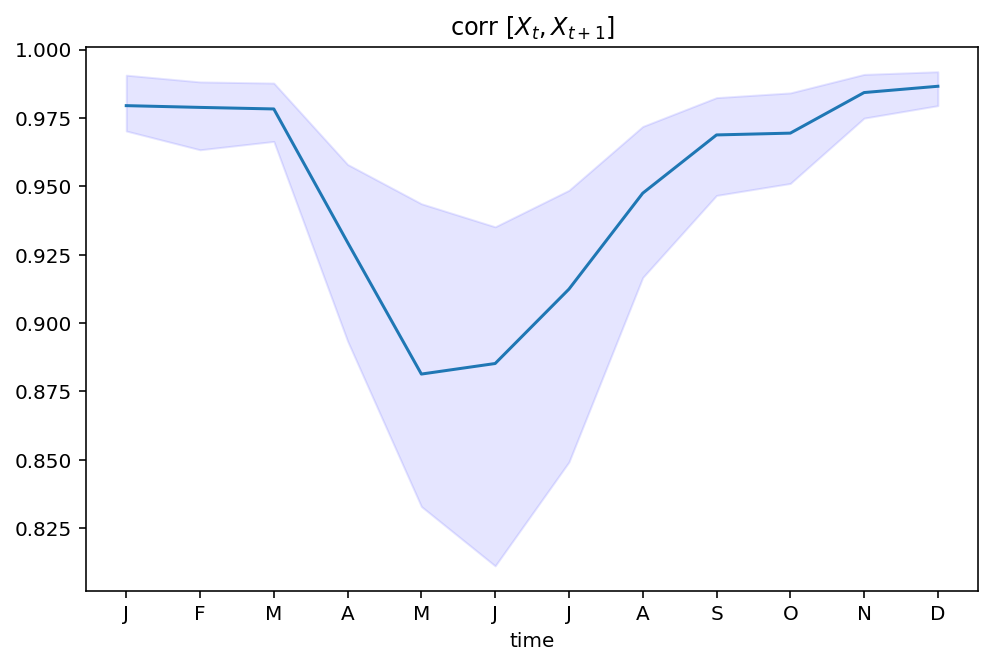

In [41]:
rho1 = np.empty(12) + np.nan
for imonth in range(0, 12):
    rho1[imonth] = cor(n34a[imonth::12], n34a.shift(T=1)[imonth::12])
    
ci = lag1_cor_by_month(n34a.values)
    
fig, ax = plt.subplots(figsize =(8, 5))    
ax.plot(rho1)
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1);
ax.set_title('corr [$X_t, X_{t+1}$]');
ax.set_xlabel('time')

## 4. (20 points) The lag-correlation of Nino 3.4 has a distinctive structure (below). 

Compute and plot the quantity 

$$ C_{t, \tau} = \text{cor} [ X_t, X_{t+\tau} ]\,, \qquad t = \text{ Jan, ..., Dec}\,, \quad \tau = 1, \dots, 12$$


for the periodic AR(1) and periodic AR(2) simulations computed above. The code below works (I think) for Nino 3.4 which is an xarray array.

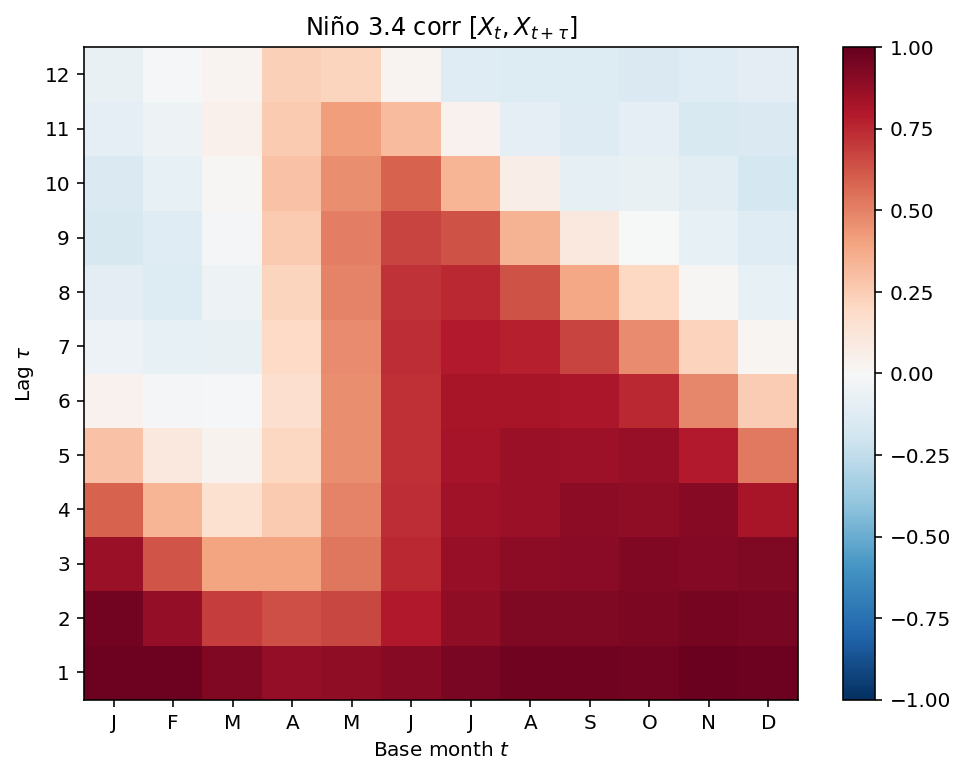

In [42]:
max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(n34a[imonth::12], n34a.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (8, 6))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Niño 3.4 corr $[X_t, X_{t + \tau}]$');

### Periodic AR(1)

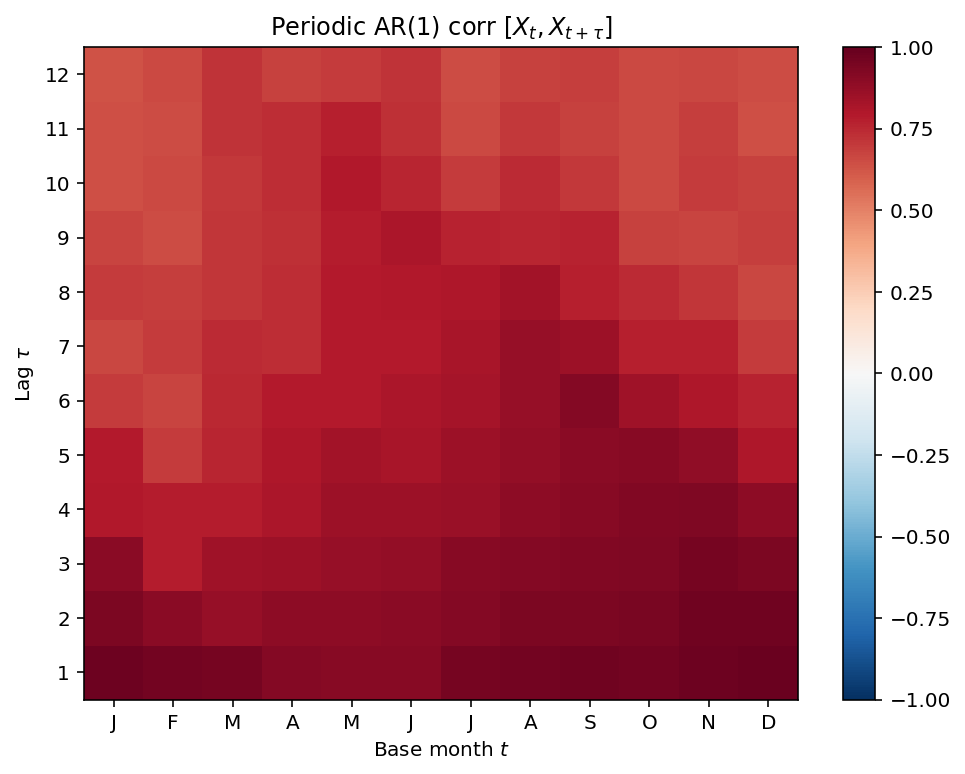

In [50]:
ar1 = n34a.copy()
ar1[1:] = x_periodic_AR1

max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(ar1[imonth::12], ar1.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (8, 6))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Periodic AR(1) corr $[X_t, X_{t + \tau}]$');

### Periodic AR(2)

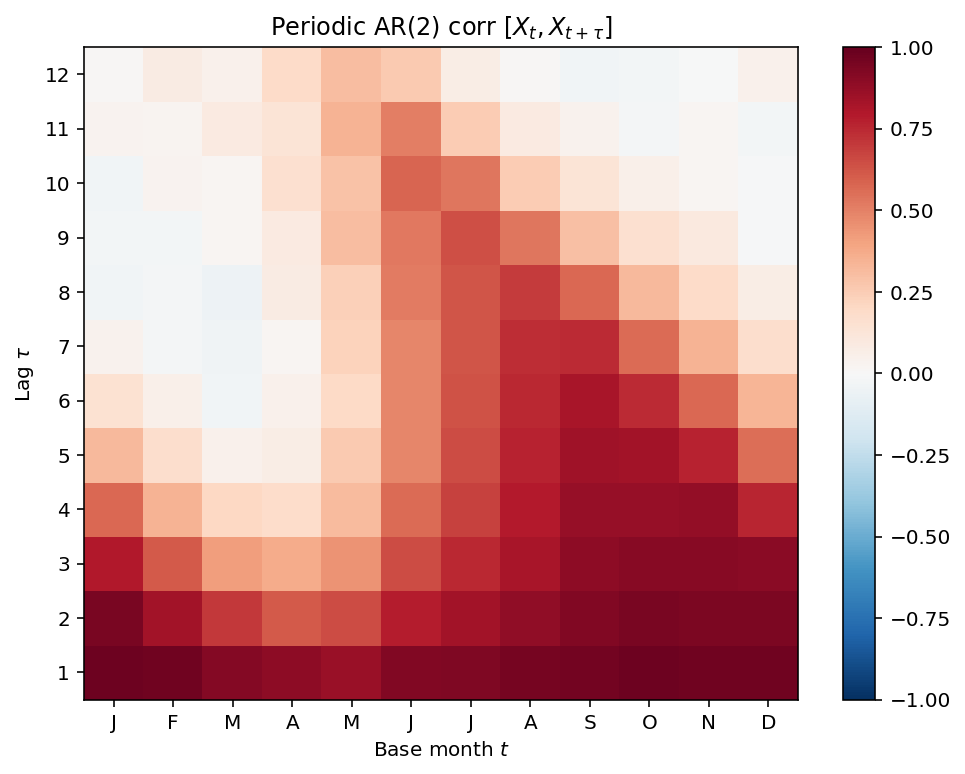

In [51]:
ar2 = n34a.copy()
ar2[2:] = x_periodic_AR2

max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(ar2[imonth::12], ar2.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (8, 6))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Periodic AR(2) corr $[X_t, X_{t + \tau}]$');

From the plots of the correlation, it appears that the AR(2) model does a much better job at simulating the correlations of the Nino 3.4 Index than the AR(1) model. 